## Using Bartiq for Resource Analysis

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

This tutorial, as well as all the other tutorials, has been written as a jupyter notebook.
If you're reading it online, you can either keep reading, or clone the repository and go to `docs/tutorials` to explore them in a more interactive way!

</div>

It is time to test the utility of Bartiq's resource estimation in practical applications. Beyond the Uniform State Preparation (USP) method described in [Tutorial 2](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/), there are several other implementations of USP worth considering.

### USP Implementations

We will analyze three distinct uniform state preparation routines:

1. **USP**: The basic uniform state preparation routine introduced in [arXiv:1805.03662](https://arxiv.org/abs/1805.03662).

2. **RealUSP**: An enhanced version of the original USP, which provides improved efficiency as detailed in [arXiv:2011.03494](https://arxiv.org/abs/2011.03494).

3. **ZeroAncillaUSP**: A more recent construction that eliminates the need for any ancilla qubits, as presented in [arXiv:2306.11747](https://arxiv.org/abs/2306.11747).

Throughout this notebook, we will refer to these routines as USP, RealUSP, and ZeroAncillaUSP respectively. Each method will be considered and analyzed to determine the resources required for their implementation.

# USP

The implementation of the Uniform State Preparation (USP) method is described in [Tutorial 2](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/). Let's do a quick recap.

### Parameters

The parameter part of this method is the same as in [Tutorial 2](https://psiq.github.io/bartiq/latest/tutorials/02_alias_sampling_basic/). To prepares a state which is a uniform superposition over $L$ basis states:

- $L$: Number of coefficients we want to load.
- $k$: The largest integer such that $2^k$ divides $L$ , $k = multiplicity(2, L)$.

These expressions only valid if $L$ is not a power of two.

In [1]:
import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

from bartiq import evaluate, compile_routine
from bartiq.integrations import qref_to_bartiq

# plotting
import matplotlib.pyplot as plt
import math
import numpy as np
import sympy

In [2]:
usp_dict = {
    "name": "usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "resources": [
        {
            "name": "T_gates",
            "type": "additive",
            "value": "8*ceil(log_2(L/(2 ** multiplicity(2,L)))-1)",
        },
        {"name": "rotations", "type": "additive", "value": "2"},
    ],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))"},
}

In [3]:
usp = {"version": "v1", "program": usp_dict}
print(usp)

{'version': 'v1', 'program': {'name': 'usp', 'type': None, 'ports': [{'name': 'in', 'direction': 'input', 'size': 'R'}, {'name': 'out', 'direction': 'output', 'size': 'R'}], 'resources': [{'name': 'T_gates', 'type': 'additive', 'value': '8*ceil(log_2(L/(2 ** multiplicity(2,L)))-1)'}, {'name': 'rotations', 'type': 'additive', 'value': '2'}], 'input_params': ['L'], 'local_variables': {'R': 'ceiling(log_2(L))'}}}


In [4]:
uncompiled_usp = qref_to_bartiq(usp)
compiled_usp = compile_routine(uncompiled_usp)
for resource in compiled_usp.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 8*ceiling(log2(L/2 ^ multiplicity(2, L))) - 8
rotations: 2


### An Example Numerical Estimation

In [5]:
assignments = {"L=7"}

evaluated_usp = evaluate(compiled_usp, assignments)
for resource in evaluated_usp.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 16
rotations: 2


# Zero Ancilla USP

[arXiv:2306.11747](https://arxiv.org/abs/2306.11747) provides an alternative approach of USP that eliminates the need for ancilla qubits while maintains similar asymptotic scaling to traditional methods, we'll refer to as the Zero Ancilla USP.  The gate count for this method is detailed in Section 2.5 of the paper. We'll focus on the non-Clifford gate overhead and ignore the Clifford costs here for better comparison.

To create a uniform superposition of $\( L \)$ basis states using the Zero Ancilla USP method, the following non-Clifford gate overhead is required:

### Non-Clifford Gate Overhead

- **$\( RY(\theta) \) $Gate:** 1 
- **Controlled Hadamard Gates:** $\( l_k - l_0 \) $
- **Controlled $\( RY(\theta) \)$ Gates:** $\( k - 1 \) $

### Parameters

- **$\( l_0, l_1, \ldots, l_k \):$** This is a sequence of integers where $\( L = \sum_{j=0}^k 2^{l_j} \)$ and $\( 0 \le l_0 < l_1 < \ldots < l_{k-1} < l_k \le n-1 \)$. In simpler terms:
  - $\( l_0 \)$ is the position of the trailing zero in the binary representation of $\( L \)$.
  - $\( l_k \)$ is the position of the highest set bit, or $\( \lfloor \log_2(L) \rfloor \)$.
  - $\( k \)$ is the number of non-zero bits in the binary representation of $\( L \)$.

Using these parameters, you can determine the specific gate overhead required for the Zero Ancilla USP method in Bartiq.



In [6]:
zeroanc_usp = {
    "name": "zeroanc_usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "input_params": ["L"],
    "local_variables": {
        "l_0": "trailing(L)",
        "R": "ceil(log2(L))",
        "l_k": "floor(log2(L))",
        "k": "bin_bitcount(L) - 1 ",
    },
    "resources": [
        {"name": "rotations", "type": "additive", "value": "1"},
        {"name": "control_ry", "type": "additive", "value": "k - 1"},
        # {"name": "rotations", "type": "additive", "value": "2*k-1"},
        {"name": "control_H", "type": "additive", "value": "l_k - l_0"},
        # {"name": "T_gates", "type": "additive", "value": "2*l_k - 2*l_0"},
    ],
}

In [7]:
zeroanc = {"version": "v1", "program": zeroanc_usp}

In [8]:
uncompiled_zeroanc = qref_to_bartiq(zeroanc)

Here, we can try an advanced function to help decompose these gates into more basic, more general non-Clifford gates. This function accepts a dictionary that specifies how to decompose the gates and an uncompiled BARTIQ routine as parameters. It will synthesize all matching resources within the BARTIQ routine according to the dictionary.

In [9]:
from bartiq.transform import add_aggregated_resources

aggregation_dict = {"control_ry": {"rotation": 2, "CNOT": 2}, "control_H": {"T_gates": 2}, "rotation": {"T_gates": 50}}
aggregated_zeroanc = add_aggregated_resources(uncompiled_zeroanc, aggregation_dict)
print(aggregated_zeroanc)

name='zeroanc_usp' type=None ports={'in': Port(zeroanc_usp.#in, size="R", input), 'out': Port(zeroanc_usp.#out, size="R", output)} parent=None children={} connections=[] resources={'rotations': <Resource name="rotations" value="1">, 'T_gates': <Resource name="T_gates" value="100*k - 2*l_0 + 2*l_k - 100">, 'CNOT': <Resource name="CNOT" value="2*k - 2">} input_params=['L'] local_variables={'l_0': 'trailing(L)', 'R': 'ceil(log2(L))', 'l_k': 'floor(log2(L))', 'k': 'bin_bitcount(L) - 1 '} linked_params={} meta={}


In [10]:
compiled_zeroanc = compile_routine(uncompiled_zeroanc)

In [11]:
def trailing(x):
    return sympy.trailing(x)


def bin_bitcount(x):
    return bin(x).count("1")


functions_map = {"trailing": trailing, "bin_bitcount": bin_bitcount}
assignments_list = [
    [f"L={3}"],
    [f"L={5}"],
    [f"L={6}"],
    [f"L={7}"],
    [f"L={127}"],
]

for assignments in assignments_list:
    evaluated_zeroanc = evaluate(compiled_zeroanc, assignments, functions_map=functions_map)
    print(f"Assignment: {assignments[0]}")
    for resource in evaluated_zeroanc.resources.values():
        print(f"  {resource.name}: {resource.value}")

Assignment: L=3
  rotations: 1
  T_gates: 2
  CNOT: 0
Assignment: L=5
  rotations: 1
  T_gates: 4
  CNOT: 0
Assignment: L=6
  rotations: 1
  T_gates: 2
  CNOT: 0
Assignment: L=7
  rotations: 1
  T_gates: 104
  CNOT: 2
Assignment: L=127
  rotations: 1
  T_gates: 512
  CNOT: 10


## Repeat-Until-Success (RUS) USP

Besides, we have another method of state preparation through a variation of [arXiv:1805.03662](https://arxiv.org/abs/1805.03662), namely the Repeat-Until-Success (RUS) USP.

### What is RUS?

Simply put, RUS is a method where you keep trying until you succeed, discarding failed states and keeping the final successful state. Compared to the method described in the original paper, RUS omits the amplitude amplification part.


## Resource Estimation for Repetition
Below, we symbolically estimate the resources required for a single trial

In [12]:
rus_usp = {
    "name": "rus_usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "input_params": ["L"],
    "local_variables": {"k": "multiplicity(2,L)", "R": "ceiling(log_2(L))", "trial": "num_iter(L)"},
    "resources": [
        # decomposition Toffoli = 4 T_gates
        {"name": "T_gates", "type": "additive", "value": "4*trial*(R-k-1)"}
    ],
}

This estimation arises because it is equivalent to performing two cost inequality tests. Each test has a Toffoli gate count of 
$[log_2(d)⌉−k−1$. According to Craig Gidney's paper, each Toffoli gate, when the input of the controlled bit is known to be in $|0>$, can be decomposed into four T gates. Additionally, the T gate cost for the uncompute inequality test (the second one) can be ignored.

In [13]:
rus = {"version": "v1", "program": rus_usp}

In [14]:
uncompiled_rus = qref_to_bartiq(rus)
compiled_rus = compile_routine(uncompiled_rus)

### Repetition Number

The probability of success in each trial is determined by the ratio of L  to the smallest power of 2 that is greater than or equal to  L.
This function  below provides a rough estimation of the number of trials needed to achieve a target success probability (default is 99%) based on the geometric distribution. This means it may not match the actual number of trials required each time, but it helps with estimation. 




In [15]:
def calculate_trials(d, target_probability=0.99):
    prob = d / (1 << math.ceil(math.log2(d)))
    return math.ceil(math.log(1 - target_probability) / math.log(1 - prob))

Here's how you can estimate the number of trials:

In [16]:
num_trials = calculate_trials(7)
print(f"The estimated number of trials needed is: {num_trials}")

The estimated number of trials needed is: 3


## Total Resource Estimation
By combining the estimated repetition number with the resource estimation for a single repetition, we can complete the symbolic estimation of the total resources required.

For example, if resources_per_trial represents the resources required for one trial, the total resources needed for L=7 can be calculated as follows:

In [17]:
assignments = [f"L={7}"]

functions_map = {"num_iter": calculate_trials}
evaluated_rus = evaluate(compiled_rus, assignments, functions_map=functions_map)
for resource in evaluated_rus.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 24


## Comparison

Now, we can compare the cost performance of different USP methods for some specific data.

## Make the Samples

In [18]:
def is_power_of_two(n):
    return (n & (n - 1) == 0) and n != 0


all_values = np.arange(5, 1000)

filtered_values = [x for x in all_values if not is_power_of_two(x)]
L_values = filtered_values[:200]

In [19]:
# USP
usp_tgates = []
usp_rotations = []


# Loop over L values and evaluate the routine
for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_usp = evaluate(compiled_usp, assignments_list)
    usp_tgates.append(math.ceil(float(evaluated_usp.resources["T_gates"].value)))
    usp_rotations.append(math.ceil(float(evaluated_usp.resources["rotations"].value)))
    if "rotations" in evaluated_usp.resources:
        usp_rotations.append(int(evaluated_usp.resources["rotations"].value))
    else:
        usp_rotations.append(0)

In [20]:
# RUS_USP
rus_tgates = []
rus_rotations = []

functions_map = {"num_iter": calculate_trials}

# Loop over L values and evaluate the routine
for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_rus = evaluate(compiled_rus, assignments_list, functions_map=functions_map)
    rus_tgates.append(int(evaluated_rus.resources["T_gates"].value))
    if "rotations" in evaluated_rus.resources:
        rus_rotations.append(int(evaluated_rus.resources["rotations"].value))
    else:
        rus_rotations.append(0)

In [21]:
# Zeroanc_USP
zeroanc_tgates = []
zeroanc_rotations = []

functions_map = {"trailing": trailing, "bin_bitcount": bin_bitcount}

# Loop over L values and evaluate the routine
for L in L_values:
    assignments_list = {f"L={L}"}
    evaluated_zeroanc = evaluate(compiled_zeroanc, assignments_list, functions_map=functions_map)
    zeroanc_tgates.append(int(evaluated_zeroanc.resources["T_gates"].value))
    if "rotations" in evaluated_zeroanc.resources:
        zeroanc_rotations.append(int(evaluated_zeroanc.resources["rotations"].value))
    else:
        zeroanc_rotations.append(0)

## Plot the Graph

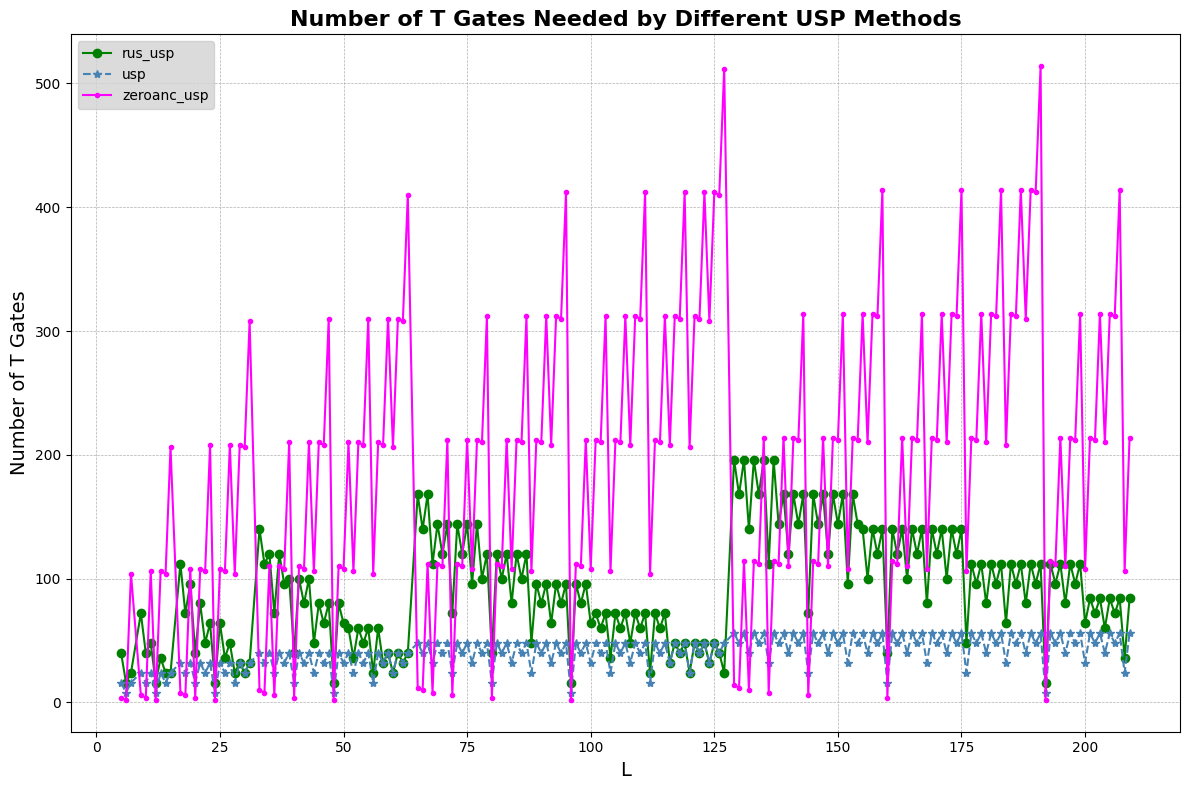

In [22]:
# Plot the resources
plt.figure(figsize=(12, 8))

plt.plot(L_values, rus_tgates, label="rus_usp", marker="o", color="green", markersize=6, linestyle="-")
plt.plot(L_values, usp_tgates, label="usp", marker="*", color="steelblue", markersize=6, linestyle="--")
plt.plot(L_values, zeroanc_tgates, label="zeroanc_usp", marker=".", color="magenta", markersize=6, linestyle="-")

plt.title("Number of T Gates Needed by Different USP Methods", fontsize=16, fontweight="bold")
plt.xlabel("L", fontsize=14)
plt.ylabel("Number of T Gates", fontsize=14)

plt.legend(title="Methods", fontsize=12, title_fontsize="13", loc="upper left", frameon=True, edgecolor="black")
plt.legend().get_frame().set_facecolor("lightgrey")

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

## Summary

In this tutorial, we explored the utility of bartiq's resource estimation in more complex scenarios.

- How to effectively utilize BARTIQ to handle nested subroutines
- How to use aggregation functions to synthesize resources